## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data",
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
train_data = prostate.drop("train", axis=1)[prostate["train"] == "T"]
test_data = prostate.drop("train", axis=1)[prostate["train"] == "F"]

scaler = StandardScaler()
scaler.fit(train_data)
train_data_std = scaler.fit_transform(train_data)
test_data_std = scaler.transform(test_data)
X_train = train_data_std[:, :-1]
y_train = train_data_std[:, -1]
X_test = test_data_std[:, :-1]
y_test = test_data_std[:, -1]

## 线性回归

In [31]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [34]:
class LinearRegression(BaseEstimator, RegressorMixin):
    """线性回归
    
    参数：
    -----
    learning_rate: 在梯度下降中，更新权重所用的步长
    epochs: 在梯度下降中，迭代所用的步数
    """
    def __init__(self, epochs=200, learning_rate=0.1):
        self.epochs = epochs
        self.learning_rate = learning_rate
        
    # 均方差损失函数
    def __mean_squared_error(self, X, W, y):
        y_pred = X @ W
        return np.sum((y - y_pred)**2) / len(y)
    
    # 负梯度
    def __negative_gradient(self, X, W, y):
        grad = -2 / len(y) * X.T @ (y - X @ W) 
        return -grad
    
    def fit(self, X, y):
        n, p = X.shape
        X = np.c_[np.ones(n), X]
        self.W = np.random.randn(p+1)
        weight_history = [self.W.copy()]
        loss = self.__mean_squared_error(X, self.W, y)
        self.loss_history = [loss]
        tol = 1e-5
        for e in range(1, self.epochs+1):
            neg_grad = self.__negative_gradient(X, self.W, y)  # 负梯度
            self.W += self.learning_rate * neg_grad # 更新权重
            weight_history.append(self.W.copy())
            weight_change = np.sum(np.abs(np.abs(weight_history[-1]) - \
                                          np.abs(weight_history[-2])))
            if weight_change < tol:
                break          
            loss = self.__mean_squared_error(X, self.W, y)
            self.loss_history.append(loss)
        if weight_change > tol and self.loss_history[-1] > tol:
            print("Linear regression dosen't converge!")
                      
        return self
    
    def predict(self, X):
        n = len(X)
        X_b = np.c_[np.ones(n), X]
        y_pred = X_b @ self.W
        return y_pred

In [35]:
lr = LinearRegression(epochs=500)
lr.fit(X_train, y_train)

LinearRegression(epochs=500, learning_rate=0.1)

In [36]:
y_pred = lr.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [37]:
y_pred = lr.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.363


In [38]:
# 系数
lr.W

array([ 5.44196670e-17,  5.93132150e-01,  2.42299177e-01, -1.18034828e-01,
        1.75529770e-01,  2.56370758e-01, -2.39269742e-01, -1.72372841e-02,
        2.29541816e-01])

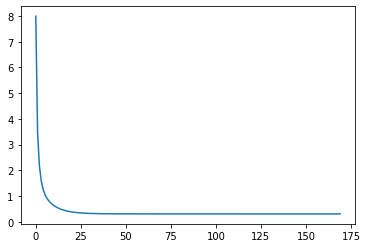

In [40]:
# 绘制历史损失值曲线
loss_history = lr.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 使用 `Sklearn`

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
sk_lr = LinearRegression()
sk_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
y_train_preds = sk_lr.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [28]:
y_test_preds = sk_lr.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.363


In [29]:
pd.options.display.float_format = '{:.3f}'.format
variables = ["Intercept"] + list(train_data.iloc[:, :-1].columns)
pd.DataFrame({"变量": variables, "值": np.r_[sk_lr.intercept_, sk_lr.coef_]})

,变量,值
0,Intercept,0.000
1,lcavol,0.593
2,lweight,0.242
3,age,-0.118
4,lbph,0.176
5,svi,0.256
6,lcp,-0.239
7,gleason,-0.017
8,pgg45,0.230
